In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt
%matplotlib inline

# Set a random seed
np.random.seed(42)


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

Simple classifier with data reloading and fidelity loss
=======================================================


In [4]:
def reshape_x(input_array):
    # Calculate the number of subarrays needed
    num_subarrays = len(input_array) // 3 + (len(input_array) % 3 != 0)

    # Split the array into subarrays of size 3
    subarrays = [input_array[i * 3:(i + 1) * 3] for i in range(num_subarrays)]

    # Check if the last subarray has fewer than 3 elements and pad with zeros if necessary
    if len(subarrays[-1]) < 3:
        subarrays[-1] = np.pad(subarrays[-1], (0, 3 - len(subarrays[-1])), mode='constant')
        
    return subarrays

dev = qml.device("lightning.gpu", wires=2)

@qml.qnode(dev, interface="autograd")
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for l in range(params.shape[0]): # Iterate num_layers times
        w_0 = params[l, 0]
        b_0 = params[l, 1]
        w_1 = params[l, 2]
        b_1 = params[l, 3]
        
        encoding_0 = w_0 * x + b_0
        encoding_0 = reshape_x(encoding_0)
        
        encoding_1 = w_1 * x + b_1
        encoding_1 = reshape_x(encoding_1)
        
        for i in range(len(encoding_0)):
            qml.Rot(*(encoding_0[i]), wires=0)
            qml.Rot(*(encoding_1[i]), wires=1)
        
        qml.CZ([0, 1]) 
    
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

Utility functions for testing and creating batches
==================================================


In [5]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Train a quantum classifier on the circle dataset
================================================


In [6]:
# Generate training and test data
num_training = 500
num_test = 200

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))



In [7]:

# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2*2, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.412889 | Train accuracy: 0.514000 | Test Accuracy: 0.535000
Epoch:  1 | Loss: 0.206479 | Train accuracy: 0.662000 | Test accuracy: 0.605000
Epoch:  2 | Loss: 0.166887 | Train accuracy: 0.752000 | Test accuracy: 0.745000
Epoch:  3 | Loss: 0.148350 | Train accuracy: 0.774000 | Test accuracy: 0.770000
Epoch:  4 | Loss: 0.114843 | Train accuracy: 0.864000 | Test accuracy: 0.890000
Epoch:  5 | Loss: 0.103501 | Train accuracy: 0.882000 | Test accuracy: 0.930000
Epoch:  6 | Loss: 0.102473 | Train accuracy: 0.898000 | Test accuracy: 0.935000
Epoch:  7 | Loss: 0.101542 | Train accuracy: 0.898000 | Test accuracy: 0.935000
Epoch:  8 | Loss: 0.101275 | Train accuracy: 0.896000 | Test accuracy: 0.935000
Epoch:  9 | Loss: 0.101135 | Train accuracy: 0.900000 | Test accuracy: 0.935000
Epoch: 10 | Loss: 0.101026 | Train accuracy: 0.900000 | Test accuracy: 0.930000


Results
=======


Cost: 0.101026 | Train accuracy 0.900000 | Test Accuracy : 0.930000
Learned weights
Layer 0: [[ 0.16704191  0.66604015  0.03667143]
 [ 0.73640202  1.19515101 -0.32667629]
 [ 0.84417045  0.94716214  0.58535436]
 [ 0.86827128  0.03182029 -0.12691818]]
Layer 1: [[ 1.07704119  0.5259198   0.53116953]
 [ 0.13529853  0.71578752 -0.32767742]
 [ 0.94955256  0.75650537  0.3161561 ]
 [ 0.26839701 -0.02819007  0.1483432 ]]
Layer 2: [[1.18466063 0.65811989 0.00493998]
 [0.50202445 1.22090987 0.86791829]
 [0.45473986 0.51559603 0.48884658]
 [0.66686426 0.13965125 0.02997359]]


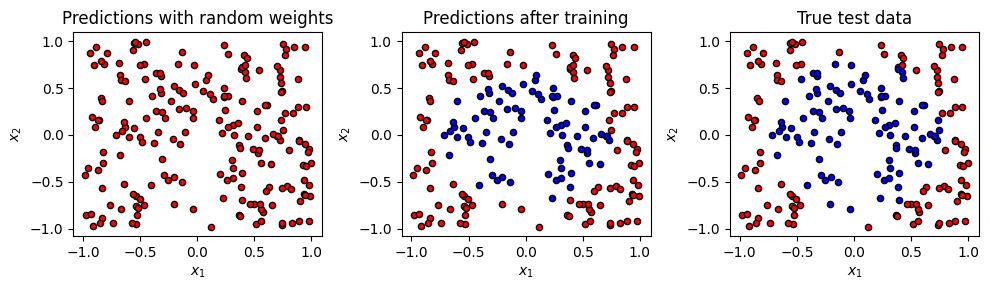

In [8]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

# Hypercubic Data

In [14]:
from sklearn.datasets import make_classification

n_samples = 500
n_features = 3
n_informative = 3
n_classes = 2

num_layers = 10
learning_rate = 0.6
epochs = 10
batch_size = 32

    
    # n_samples = 500
    # n_features = 6
    # n_informative = 2
    # n_redundant = 4
    # n_classes = 2

# Create a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=(n_features - n_informative),
    n_classes=n_classes,
    class_sep=10.,
    random_state=0
)

# X = np.array(X)
# y = np.array(y)

# set training and test data
split = int(0.8 * n_samples)
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:, :]
y_test = y[split:]

In [16]:
%%time
# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.05, momentum=0.8)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2*2, n_features), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.248807 | Train accuracy: 0.565000 | Test Accuracy: 0.640000
Epoch:  1 | Loss: 0.227928 | Train accuracy: 0.600000 | Test accuracy: 0.650000
Epoch:  2 | Loss: 0.080522 | Train accuracy: 0.932500 | Test accuracy: 0.950000
Epoch:  3 | Loss: 0.075962 | Train accuracy: 0.972500 | Test accuracy: 0.930000
Epoch:  4 | Loss: 0.116666 | Train accuracy: 0.872500 | Test accuracy: 0.870000
Epoch:  5 | Loss: 0.308871 | Train accuracy: 0.467500 | Test accuracy: 0.460000
CPU times: user 54.7 s, sys: 18.3 ms, total: 54.8 s
Wall time: 59.3 s


# High-dimensional Annulus

In [17]:
import pandas as pd
import plotly.express as px
import numpy as np


def annulus(samples, dimensions, inner_radius=1.0, outer_radius=2.0):
    """
    Generates an n-dimensional dataset of points with 1/0 labels inside an annulus.

    Args:
        samples (int): number of samples to generate
        dimensions (int): number of dimensions for the dataset
        center (array): center of the annulus
        inner_radius (float): inner radius of the annulus
        outer_radius (float): outer radius of the annulus

    Returns:
        Xvals (array): coordinates of points
        yvals (array): classification labels
    """
    Xvals, yvals = [], []
    center = np.zeros(dimensions)
    
    for i in range(samples):
        x = 2 * (np.random.rand(dimensions)) - 1
        y = 0
        distance_to_center = np.linalg.norm(x - center)
        
        if inner_radius < distance_to_center < outer_radius:
            y = 1
        
        Xvals.append(x)
        yvals.append(y)

    return np.array(Xvals), np.array(yvals)


samples = 1000
dimensions = 6
X_train, y_train = annulus(samples, dimensions, inner_radius=0.0, outer_radius=0.8)
X_test, y_test = annulus(samples, dimensions, inner_radius=0.0, outer_radius=0.8)

# df = pd.DataFrame(X_train[:, :3], columns=[f'Dimension {i+1}' for i in range(3)])
# df['Label'] = y_train

# # Create an interactive 3D scatter plot
# fig = px.scatter_3d(df, x='Dimension 1', y='Dimension 2', z='Dimension 3', color='Label',
#                     symbol='Label', opacity=0.5, title='3D Annulus Dataset')

# # Show the plot
# fig.show()

In [19]:
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane import numpy as np

# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32



opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2*2, dimensions), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)
# print('loss: ', loss)
# print('accuracy_train: ', accuracy_train)
# print('accuracy_test: ', accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]

    print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        it+1, loss, accuracy_train, accuracy_test
    )
)

Epoch:  0 | Cost: 0.114042 | Train accuracy: 0.892000 | Test Accuracy: 0.888000
Epoch:  1 | Cost: 0.028587 | Train accuracy: 0.975000 | Test Accuracy: 0.973000
Epoch:  2 | Cost: 0.025056 | Train accuracy: 0.976000 | Test Accuracy: 0.974000
Epoch:  3 | Cost: 0.024320 | Train accuracy: 0.976000 | Test Accuracy: 0.974000
Epoch:  4 | Cost: 0.023969 | Train accuracy: 0.976000 | Test Accuracy: 0.974000
Epoch:  5 | Cost: 0.023752 | Train accuracy: 0.976000 | Test Accuracy: 0.974000


# Hypercubic Clusters 

In [20]:
%%time
from pennylane import numpy as np
from sklearn.datasets import make_classification


n_samples = 500
n_features = 6
n_informative = 4
n_classes = 2

num_layers = 10
learning_rate = 0.6
epochs = 10
batch_size = 32

    
    # n_samples = 500
    # n_features = 6
    # n_informative = 2
    # n_redundant = 4
    # n_classes = 2

# Create a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=(n_features - n_informative),
    n_classes=n_classes,
    class_sep=2.,
    random_state=0
)

# X = np.array(X)
# y = np.array(y)

# set training and test data
split = int(0.8 * n_samples)
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:, :]
y_test = y[split:]


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2*2, n_features))
params = np.array(params, requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.287037 | Train accuracy: 0.575000 | Test Accuracy: 0.580000
Epoch:  1 | Loss: 0.141584 | Train accuracy: 0.815000 | Test accuracy: 0.690000
Epoch:  2 | Loss: 0.108537 | Train accuracy: 0.875000 | Test accuracy: 0.830000
Epoch:  3 | Loss: 0.087621 | Train accuracy: 0.900000 | Test accuracy: 0.850000
Epoch:  4 | Loss: 0.076649 | Train accuracy: 0.935000 | Test accuracy: 0.930000
Epoch:  5 | Loss: 0.072678 | Train accuracy: 0.940000 | Test accuracy: 0.940000
CPU times: user 1min 51s, sys: 27.6 ms, total: 1min 51s
Wall time: 2min 1s


In [ ]:
%%time
from pennylane import numpy as np
from sklearn.datasets import make_classification


n_samples = 500
n_features = 9
n_informative = 7
n_classes = 2

num_layers = 10
learning_rate = 0.6
epochs = 10
batch_size = 32

    
    # n_samples = 500
    # n_features = 6
    # n_informative = 2
    # n_redundant = 4
    # n_classes = 2

# Create a synthetic dataset with 2 classes
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=(n_features - n_informative),
    n_classes=n_classes,
    class_sep=2.,
    random_state=0
)

# X = np.array(X)
# y = np.array(y)

# set training and test data
split = int(0.8 * n_samples)
X_train = X[:split, :]
y_train = y[:split]
X_test = X[split:, :]
y_test = y[split:]


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 5
batch_size = 32

opt = NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)

# initialize random weights
params = np.random.uniform(size=(num_layers, 2*2, n_features))
params = np.array(params, requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.297382 | Train accuracy: 0.497500 | Test Accuracy: 0.470000
Epoch:  1 | Loss: 0.223303 | Train accuracy: 0.645000 | Test accuracy: 0.540000
Epoch:  2 | Loss: 0.201048 | Train accuracy: 0.682500 | Test accuracy: 0.630000
Epoch:  3 | Loss: 0.190570 | Train accuracy: 0.710000 | Test accuracy: 0.720000
Epoch:  4 | Loss: 0.168658 | Train accuracy: 0.775000 | Test accuracy: 0.730000
Epoch:  5 | Loss: 0.158353 | Train accuracy: 0.772500 | Test accuracy: 0.700000
